![](../img/563_banner.png)

# Lecture 8: Recommender Systems Part 2

UBC Master of Data Science program, 2024-25

## Lecture plan, imports, and LOs

### Imports 

In [1]:
import os
import random
import sys
import time

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate, train_test_split

pd.set_option("display.max_colwidth", 0)

DATA_DIR = os.path.join(os.path.abspath(".."), "data/")
sys.path.append(os.path.join(os.path.abspath(".."), "code"))

<br><br>

### Lecture plan

- Recap (~15 mins)
- Content-based filtering (20 mins)
- Course evaluations (~10 mins)
- Break (~5 mins)
- Questions for class discussion ( ~5 mins)
- Miscellaneous topics (~10 mins)
- Final comments, summary, reflection (~5 mins)

<br><br>

### Learning outcomes

From this lecture, students are expected to be able to:
- Distinguish between dot product and cosine similarity in recommender systems by explaining how each metric influences recommendations.
  
- Formulate the rating prediction problem as a supervised machine learning problem. 
- Create a content-based filter given ratings data and item features to predict missing ratings in the utility matrix.  
- Discuss differences, advantages and disadvantages between content-based filtering and collaborative filtering.
- Explain the idea of hybrid approaches at a high level. 
- Create and work with a sparse utility matrix for datasets with large number of items and users.   
- Name different kinds of data which occur in the context of recommendation systems. 
- Discuss important considerations in recommendation systems beyond error rate. 

## 1. Recap
<hr>

### 1.1 Recap: Recommender systems problem 

- We are usually given ratings data. 
- We use this data to create **utility matrix** which encodes interactions between users and items. 
- The utility matrix has many missing entries. 
- We defined recommendation systems problem as **matrix completion problem**.

![](../img/utility_matrix.png)  

Let's load some toy data. 

In [2]:
toy_ratings = pd.read_csv(DATA_DIR + "toy_ratings.csv")
toy_ratings

user_id            movie_id  rating
0   Sam     Lion King           4     
1   Sam     Jerry Maguire       4     
2   Sam     Roman Holidays      5     
3   Sam     Downfall            1     
4   Eva     Titanic             2     
5   Eva     Jerry Maguire       1     
6   Eva     Inception           4     
7   Eva     Man on Wire         5     
8   Eva     The Social Dilemma  5     
9   Pat     Titanic             3     
10  Pat     Lion King           4     
11  Pat     Bambi               4     
12  Pat     Cast Away           3     
13  Pat     Jerry Maguire       5     
14  Pat     Downfall            2     
15  Pat     A Beautiful Mind    3     
16  Jim     Titanic             2     
17  Jim     Lion King           3     
18  Jim     The Social Dilemma  5     
19  Jim     Malcolm x           4     
20  Jim     Man on Wire         5

In [3]:
N = len(np.unique(toy_ratings["user_id"]))
M = len(np.unique(toy_ratings["movie_id"]))
print(f"Number of users (N): {N}")
print(f"Number of movies (M): {M}")

Number of users (N): 4
Number of movies (M): 12


In [4]:
user_key = "user_id"
item_key = "movie_id"
user_mapper = dict(zip(np.unique(toy_ratings[user_key]), list(range(N))))
item_mapper = dict(zip(np.unique(toy_ratings[item_key]), list(range(M))))
user_inverse_mapper = dict(zip(list(range(N)), np.unique(toy_ratings[user_key])))
item_inverse_mapper = dict(zip(list(range(M)), np.unique(toy_ratings[item_key])))

def create_Y_from_ratings(data, N, M):
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        Y[n, m] = val["rating"]

    return Y

In [5]:
Y = create_Y_from_ratings(toy_ratings, N, M)
utility_mat = pd.DataFrame(Y, columns=item_mapper.keys(), index=user_mapper.keys())
utility_mat

A Beautiful Mind  Bambi  Cast Away  Downfall  Inception  Jerry Maguire  \
Eva NaN               NaN    NaN        NaN        4.0        1.0             
Jim NaN               NaN    NaN        NaN       NaN        NaN              
Pat  3.0               4.0    3.0        2.0      NaN         5.0             
Sam NaN               NaN    NaN         1.0      NaN         4.0             

     Lion King  Malcolm x  Man on Wire  Roman Holidays  The Social Dilemma  \
Eva NaN        NaN         5.0         NaN              5.0                  
Jim  3.0        4.0        5.0         NaN              5.0                  
Pat  4.0       NaN        NaN          NaN             NaN                   
Sam  4.0       NaN        NaN           5.0            NaN                   

     Titanic  
Eva  2.0      
Jim  2.0      
Pat  3.0      
Sam NaN

<br><br>

### 1.2 Recap: Main approaches

- Collaborative filtering (last lecture)
    - "Unsupervised" learning 
    - We only have labels $y_{ij}$ (rating of user $i$ for item $j$). 
    - We learn latent features.  
- **Content-based recommenders (today's focus)**
    - Supervised learning
    - Extract features $x_i$ of users and/or items building a model to predict rating $y_i$ given $x_i$. 
    - Apply model to predict for new users/items. 
- Hybrid 
    - Combining collaborative filtering with content-based filtering
    

<br><br>

### 1.3 Recap: Collaborative filtering 
In the last lecture we talked about collaborative filtering
- **People who agreed in the past are likely to agree again in future.**
  
- "Unsupervised" learning 
    - We only have labels $Y$ (ratings $y_{ij}$ for user $i$ and item $j$) but no features of items or users. 
- We use PCA-like approach to learn the latent features of users and items.
- You can think of $Z$ matrix as user embeddings and $W$ matrix as item embeddings. 
- Then the predicted rating is multiplication of a corresponding user and item embeddings.  
- The key idea is that the loss function only includes the available ratings and regularization terms for $W$ and $Z$ to avoid overfitting. 
- So instead of using the regular PCA or `TruncatedSVD`, we implement our own loss function or use a package which implements this loss function (e.g., surprise package or write your own PyTorch code).

![](../img/toy-movie-pred.png)

### 1.4 Measuring similarity/distances

- After training a collaborative filtering model, we have user embeddings and item embeddings.
  
- We use these embeddings to make recommendations.
- In particular, these embeddings are used to match users with items or to find users with similar preferences and items with similar characteristics.
- So the notion of **similarity** or **distances** plays a crucial role in this context

- There are two primary similarity measures used in this context: 

    - **Dot products** measure the similarity through the alignment of vectors in a high-dimensional space. Higher dot product means a greater degree of similarity, assuming that the vectors are non-negative.  
    $$similarity_{dot\_product}(u, v) = u.v$$  

    - **Cosine similarity** measures the cosine of the angle between two vectors
    $$similarity_{cosine}(u,v) = cosine(u,v) = \frac{u.v}{\left\lVert u\right\rVert_2 \left\lVert v\right\rVert_2}$$

**Discussion question**

_Imagine that you recently watched **Minimalism: A Documentary About the Important Things (2015)** and rated it highly._

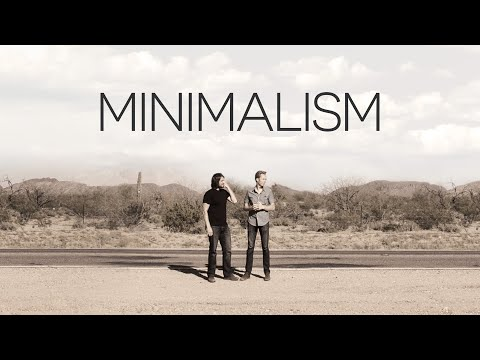

In [6]:
from IPython.display import YouTubeVideo
video_id = "0Co1Iptd4p4"
YouTubeVideo(video_id, width=800, height=450)

Suppose a recommendation system suggests items based on item similarity. Depending on the similarity metric used, which movie would be recommended to you?

- A) 🎬 Avatar: The Way of Water (2022) (Highly popular sci-fi movie with themes of nature and connection.)

- B) 🎬 The Art of Effortless Living (2021) (A lesser-known documentary about mindfulness and simple living.)


<br><br><br><br>

Given a query vector "Query" in the picture below and the three item vectors, determine the ranking of the items for the three similarity measures below: 

- **Example: Similarity based on Euclidean distance: item 3 > item 1 > item 2**
  
- Similarity based on dot product: **item 2 > item 3 > item 1**
  
- Cosine similarity: **item 1 > item 2 > item 3**

<img src="../img/distance-metrics.png" alt="" height="200" width="300"> 

<!-- ![](../img/distance-metrics.png) -->

- Adapted from [here](https://developers.google.com/machine-learning/recommendation/overview/candidate-generation).

**Which similarity metric to use in what context?**

- The choice of similarity metric can have a significant impact on the behavior of the recommendation system.

**Dot product similarity**
-  Larger norms can lead to higher similarity scores, which means that items with larger norms are more likely to be recommended.
  
- If popularity is an important factor for recommendations in your system, this characteristic of the dot product can be beneficial because it naturally boosts recommendations of popular items.
- That said, this can also lead to a lack of diversity in recommendations because popular items might overshadow less popular, yet still relevant, items.
  
**Cosine Similarity:**

- Cosine similarity measures the cosine of the angle between two vectors, which corresponds to their directional alignment, independent of their magnitude.
  
- This means that even if an item has a large norm, it won't be recommended unless it's directionally similar to the user's preference vector.
- Cosine similarity is often used when the scale of the embeddings should not influence the recommendation, providing a more balanced field for both popular and less popular items.

<br><br><br><br>

## 2. Content-based filtering
<hr>

- What if a new item or a new user shows up?

    - You won't have any ratings information for that item or user
- Content-based filtering is suitable to predict ratings for new items and new users.
- Content-based filtering is a **supervised machine learning** approach to recommender systems. 
- In collaborative filtering we assumed that we only have ratings data. 
- Usually there is some information available about items and users. 
- Examples:
    - Netflix can describe movies as action, romance, comedy, documentaries.
      
    - Netflix has some demographic and preference information on users. 
    - Amazon could describe books according to topics: math, languages, history. 
    - Tinder could describe people according to age, location, employment.
- Can we use this information to predict ratings in the utility matrix?   
    - Yes! Using content-based filtering! 

**Overview**

In content-based filtering, 
- We assume that we are given item or user feature.
  
- Given movie information, for instance, we **create user profile for each user**.
- We treat ratings prediction problem as **a set of regression problems** and build regression model for each user.
- Once we have trained regression models for each user, we **complete the utility matrix by predicting ratings for each user** using their corresponding models. 

![](../img/content-based-filtering.png)

Let's look into each of these steps one by one with a toy example. 

### 2.1 Movie features

- Suppose we also have movie features. In particular, suppose we have information about the genre of each movie. 

In [7]:
movie_feats_df = pd.read_csv(DATA_DIR + "toy_movie_feats.csv", index_col=0)
movie_feats_df

Action  Romance  Drama  Comedy  Children  Documentary
A Beautiful Mind    0       1        1      0       0         0          
Bambi               0       0        1      0       1         0          
Cast Away           0       1        1      0       0         0          
Downfall            0       0        0      0       0         1          
Inception           1       0        1      0       0         0          
Jerry Maguire       0       1        1      1       0         0          
Lion King           0       0        1      0       1         0          
Malcolm x           0       0        0      0       0         1          
Man on Wire         0       0        0      0       0         1          
Roman Holidays      0       1        1      1       0         0          
The Social Dilemma  0       0        0      0       0         1          
Titanic             0       1        1      0       0         0

In [8]:
movie_feats = movie_feats_df.to_numpy()
movie_feats.shape

(12, 6)

- How can we use these features to predict missing ratings?
  
- Using the ratings data and movie features: 
    - Build **profiles for different users**.
      
    - Train a **supervised machine learning model for each user**.
    - Predict ratings using the trained models

<br><br>

### 2.2 Building user profiles 

For each user $i$ create a user profile as follows. 

- Consider all movies rated by $i$ and create `X` and `y` for the user:

    - Each row in `X` contains the movie features of movie $j$ rated by $i$.
      
    - Each value in `y` is the corresponding rating given to the movie $j$ by user $i$.
 
- Fit a regression model using `X` and `y`.

- Apply the model to predict ratings for new items! 

As an example, let's build a profile for pat.

In [9]:
# Which movies are rated by Pat? 

movies_rated_by_pat = toy_ratings[toy_ratings['user_id']=='Pat'][['movie_id', 'rating']]

movies_rated_by_pat

movie_id  rating
9   Titanic           3     
10  Lion King         4     
11  Bambi             4     
12  Cast Away         3     
13  Jerry Maguire     5     
14  Downfall          2     
15  A Beautiful Mind  3

In [10]:
movie_feats.shape

(12, 6)

In [11]:
# Get feature vectors of movies rated by Pat. 

pat_X = []
pat_y = []
for (index, val) in movies_rated_by_pat.iterrows():
    # Get the id of this movie rated by Pat       
    m = item_mapper[val['movie_id']]
    
    # Get the feature vector for the movie 
    pat_X.append(movie_feats[m])
    
    # Get the rating for the movie
    pat_y.append(val['rating'])

In [12]:
pd.DataFrame(pat_X, index=movies_rated_by_pat['movie_id'].tolist(), columns = movie_feats_df.columns)

Action  Romance  Drama  Comedy  Children  Documentary
Titanic           0       1        1      0       0         0          
Lion King         0       0        1      0       1         0          
Bambi             0       0        1      0       1         0          
Cast Away         0       1        1      0       0         0          
Jerry Maguire     0       1        1      1       0         0          
Downfall          0       0        0      0       0         1          
A Beautiful Mind  0       1        1      0       0         0

In [13]:
pat_y

[3, 4, 4, 3, 5, 2, 3]

Similar to how we created `X` and `y` for Pat above, the function below builds `X` and `y` for all users. 

In [14]:
from collections import defaultdict

def get_lr_data_per_user(ratings_df, d):
    lr_y = defaultdict(list)
    lr_X = defaultdict(list)
    lr_items = defaultdict(list)

    for index, val in ratings_df.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        lr_X[n].append(movie_feats[m])
        lr_y[n].append(val["rating"])
        lr_items[n].append(m)

    for n in lr_X:
        lr_X[n] = np.array(lr_X[n])
        lr_y[n] = np.array(lr_y[n])

    return lr_X, lr_y, lr_items

In [15]:
d = movie_feats_df.shape[1]
X_train_usr, y_train_usr, rated_items = get_lr_data_per_user(toy_ratings, d)

In [16]:
X_train_usr

defaultdict(list,
            {3: array([[0, 0, 1, 0, 1, 0],
                    [0, 1, 1, 1, 0, 0],
                    [0, 1, 1, 1, 0, 0],
                    [0, 0, 0, 0, 0, 1]]),
             0: array([[0, 1, 1, 0, 0, 0],
                    [0, 1, 1, 1, 0, 0],
                    [1, 0, 1, 0, 0, 0],
                    [0, 0, 0, 0, 0, 1],
                    [0, 0, 0, 0, 0, 1]]),
             2: array([[0, 1, 1, 0, 0, 0],
                    [0, 0, 1, 0, 1, 0],
                    [0, 0, 1, 0, 1, 0],
                    [0, 1, 1, 0, 0, 0],
                    [0, 1, 1, 1, 0, 0],
                    [0, 0, 0, 0, 0, 1],
                    [0, 1, 1, 0, 0, 0]]),
             1: array([[0, 1, 1, 0, 0, 0],
                    [0, 0, 1, 0, 1, 0],
                    [0, 0, 0, 0, 0, 1],
                    [0, 0, 0, 0, 0, 1],
                    [0, 0, 0, 0, 0, 1]])})

Do you think the shape of `X` and `y` for all users would be the same?

**Examining user profiles**

- Let's examine some user profiles. 

In [17]:
def get_user_profile(user_name):
    X = X_train_usr[user_mapper[user_name]]
    y = y_train_usr[user_mapper[user_name]]
    items = rated_items[user_mapper[user_name]]
    movie_names = [item_inverse_mapper[item] for item in items]
    print("Profile for user: ", user_name)
    profile_df = pd.DataFrame(X, columns=movie_feats_df.columns, index=movie_names)
    profile_df["ratings"] = y
    return profile_df

In [18]:
get_user_profile("Pat")

Profile for user:  Pat


Action  Romance  Drama  Comedy  Children  Documentary  \
Titanic           0       1        1      0       0         0             
Lion King         0       0        1      0       1         0             
Bambi             0       0        1      0       1         0             
Cast Away         0       1        1      0       0         0             
Jerry Maguire     0       1        1      1       0         0             
Downfall          0       0        0      0       0         1             
A Beautiful Mind  0       1        1      0       0         0             

                  ratings  
Titanic           3        
Lion King         4        
Bambi             4        
Cast Away         3        
Jerry Maguire     5        
Downfall          2        
A Beautiful Mind  3

- Pat seems to like Children's movies and movies with Comedy.
  
- Seems like she's not so much into romantic movies.  


In [19]:
get_user_profile("Eva")

Profile for user:  Eva


Action  Romance  Drama  Comedy  Children  Documentary  \
Titanic             0       1        1      0       0         0             
Jerry Maguire       0       1        1      1       0         0             
Inception           1       0        1      0       0         0             
Man on Wire         0       0        0      0       0         1             
The Social Dilemma  0       0        0      0       0         1             

                    ratings  
Titanic             2        
Jerry Maguire       1        
Inception           4        
Man on Wire         5        
The Social Dilemma  5

- Eva hasn't rated many movies. There are not many rows.
  
- Eva seems to like documentaries and action movies.

  
- Seems like she's not so much into romantic movies.  

<br><br>

### 2.3 Supervised approach to rating prediction

Given `X` and `y` for each user, we can now build a regression model for each user. 

In [20]:
from sklearn.linear_model import Ridge


def train_for_usr(user_name, model=Ridge()):
    X = X_train_usr[user_mapper[user_name]]
    y = y_train_usr[user_mapper[user_name]]
    model.fit(X, y)
    return model


def predict_for_usr(model, movie_names):
    feat_vecs = movie_feats_df.loc[movie_names].values
    preds = model.predict(feat_vecs)
    return preds

**A regression model for Pat**

In [21]:
user_name = "Pat"
pat_model = train_for_usr(user_name)

- Since we are training ridge model, we can examine the coefficients  
- What are the regression weights learned for Pat? 

In [22]:
col = "Coefficients for %s" % user_name
pd.DataFrame(pat_model.coef_, index=movie_feats_df.columns, columns=[col])

Coefficients for Pat
Action       0.000000            
Romance     -0.020833            
Drama        0.437500            
Comedy       0.854167            
Children     0.458333            
Documentary -0.437500

- How would Pat rate some movies she hasn't seen? 

In [23]:
movies_to_pred = ["Roman Holidays", "Malcolm x"]
pred_df = movie_feats_df.loc[movies_to_pred]
pred_df

Action  Romance  Drama  Comedy  Children  Documentary
Roman Holidays  0       1        1      1       0         0          
Malcolm x       0       0        0      0       0         1

In [24]:
user_name = "Pat"
preds = predict_for_usr(pat_model, movies_to_pred)
pred_df[user_name + "'s predicted ratings"] = preds
pred_df

Action  Romance  Drama  Comedy  Children  Documentary  \
Roman Holidays  0       1        1      1       0         0             
Malcolm x       0       0        0      0       0         1             

                Pat's predicted ratings  
Roman Holidays  4.145833                 
Malcolm x       2.437500

**A regression model for Eva**

In [25]:
user_name = "Eva"
eva_model = train_for_usr(user_name)
col = "Coefficients for %s" % user_name
pd.DataFrame(eva_model.coef_, index=movie_feats_df.columns, columns=[col])

Coefficients for Eva
Action       0.333333            
Romance     -1.000000            
Drama       -0.666667            
Comedy      -0.666667            
Children     0.000000            
Documentary  0.666667

- What are the predicted ratings for Eva for a list of movies?

In [26]:
user_name = "Eva"
preds = predict_for_usr(eva_model, movies_to_pred)
pred_df[user_name + "'s predicted ratings"] = preds
pred_df

Action  Romance  Drama  Comedy  Children  Documentary  \
Roman Holidays  0       1        1      1       0         0             
Malcolm x       0       0        0      0       0         1             

                Pat's predicted ratings  Eva's predicted ratings  
Roman Holidays  4.145833                 1.666667                 
Malcolm x       2.437500                 4.666667

<br><br>

### 2.4 Completing the utility matrix with content-based filtering

Here is the original utility matrix.  

In [27]:
utility_mat

A Beautiful Mind  Bambi  Cast Away  Downfall  Inception  Jerry Maguire  \
Eva NaN               NaN    NaN        NaN        4.0        1.0             
Jim NaN               NaN    NaN        NaN       NaN        NaN              
Pat  3.0               4.0    3.0        2.0      NaN         5.0             
Sam NaN               NaN    NaN         1.0      NaN         4.0             

     Lion King  Malcolm x  Man on Wire  Roman Holidays  The Social Dilemma  \
Eva NaN        NaN         5.0         NaN              5.0                  
Jim  3.0        4.0        5.0         NaN              5.0                  
Pat  4.0       NaN        NaN          NaN             NaN                   
Sam  4.0       NaN        NaN           5.0            NaN                   

     Titanic  
Eva  2.0      
Jim  2.0      
Pat  3.0      
Sam NaN

- Using predictions per user, we can fill in missing entries in the utility matrix. 

In [28]:
from sklearn.linear_model import Ridge

models = dict()
pred_lin_reg = np.zeros((N, M))

for n in range(N):
    models[n] = Ridge()
    models[n].fit(X_train_usr[n], y_train_usr[n])
    pred_lin_reg[n] = models[n].predict(movie_feats)

In [29]:
pd.DataFrame(pred_lin_reg, columns=item_mapper.keys(), index=user_mapper.keys())

A Beautiful Mind     Bambi  Cast Away  Downfall  Inception  \
Eva  2.333333          3.333333  2.333333   4.666667  3.666667    
Jim  2.575000          3.075000  2.575000   4.450000  3.150000    
Pat  3.291667          3.770833  3.291667   2.437500  3.312500    
Sam  3.810811          3.675676  3.810811   1.783784  3.351351    

     Jerry Maguire  Lion King  Malcolm x  Man on Wire  Roman Holidays  \
Eva  1.666667       3.333333   4.666667   4.666667     1.666667         
Jim  2.575000       3.075000   4.450000   4.450000     2.575000         
Pat  4.145833       3.770833   2.437500   2.437500     4.145833         
Sam  4.270270       3.675676   1.783784   1.783784     4.270270         

     The Social Dilemma   Titanic  
Eva  4.666667            2.333333  
Jim  4.450000            2.575000  
Pat  2.437500            3.291667  
Sam  1.783784            3.810811

- In this toy example, we assumed access to item features. Frequently, we also have access to user features, including demographic information.

- With this data, we can construct item profiles similar to user profiles and train a unique regression model for each item.

- These models enable us to predict ratings for each item individually.

- Typically, the final rating is derived from a weighted average that combines the ratings suggested by both item features and user features.

- In this toy example, we assumed that we had item features. Often we also have access to user features such as their demographic information.
  
- When such information is available, we can create item profiles similar to user profiles and train a regression model per item.
  
- We can then predict ratings for each item using these models.
- Often a weighted average of ratings given by item features and user features is used as the final rating. 

<br><br>

### 2.5 Miscellaneous comments on content-based filtering

**Collaborative filtering vs. content-based filtering**

- Latent-factor approach to collaborative filtering, where we reconstruct rating for user $i$ and item $j$ as: 
$$\hat{y}_{ij} = w_j^T z_{i}$$

    - $w_j^T$ are "latent" features or embedding of item $j$
      
    - $z_i$ are "latent" features or embedding of user $i$


- A linear model approach to content-based filtering, where we reconstruct rating for user $i$ and item $j$ as:

    $$\hat{y}_{ij} = w_i^T x_{ij}$$

    - $x_{ij}$ is a feature vector for user $i$ and item $j$
    
    - $w$ are the weights learned for user $i$
    
    - Our usual supervised learning setup for linear regression.  


**Fine-tuning your regression models**

- The feature matrix for movies can contain different types of features.

    - Example: Plot of the movie (text features), actors (categorical features), year of the movie, budget and revenue of the movie (numerical features).
  
    - You'll apply our usual preprocessing techniques to these features.
 
- If you have enough data, you could also carry out hyperparameter tuning with cross-validation for each model.

- Finally, although we have been talking about linear models above, you can use any regression model of your choice. 

**Advantages of content-based filtering**

- We don't need many users to provide ratings for an item.
  
- Each user is modeled separately, so you might be able to capture uniqueness of taste.

- Since you can obtain the features of the items, you can immediately recommend new items. 
    - This would not have been possible with collaborative filtering. 
- Recommendations are more interpretable (if you use linear models)
    - You can explain to the user why you are recommending an item because you have learned weights.

**Disadvantages of content-based filtering**

- Feature acquisition and feature engineering
    - What features should we use to explain the difference in ratings?

    - Obtaining those features for each item might be very expensive.
 
- Less diversity: hardly recommend an item outside the user's profile. 

<br><br>

### 2.6 (Optional) Hybrid approaches

- Both collaborative filtering and content-based filtering have their own advantages and  suffer from their shortcomings.
  
- Collaborative filtering exploits social information but it does not predict well for new movies/users.


    - New movies don't yet have ratings, and new users haven't rated anything.
      
- Content-based approaches do not have this problem but they are less diverse and do not exploit information about similarity between users.


- Can we combine the best of the two worlds? 
- There are several ways to combine collaborative filtering and content-based filtering: 
    - Build separate models for collaborative filtering and content-based filtering and combine their results. For example, the predicted rating can be a weighted average of ratings predicted by each model.
      
    - Include content-based item features in the collaborative filtering loss function. (Check out [SVDfeature](https://www.jmlr.org/papers/v13/chen12a.html) (won "KDD Cup" in 2011 and 2012).) 

<br><br><br><br>

## ❓❓ Questions for you

### Exercise 8.1 Select all of the following statements which are **True** (iClicker)

- (A) In content-based filtering we leverage available item features in addition to similarity between users.
- (B) In content-based filtering you represent each user in terms of **known** features of items whereas in collaborative filtering each user is represented with **latent** features of items. 
- (C) In the set up of content-based filtering we discussed, if you have a new movie, you would have problems predicting ratings for that movie. 
- (D) Interpretation of recommendations might be easier with content-based filtering compared to collaborative filtering.

- (E) In content-based filtering if a user has a number of ratings in the training utility matrix but does not have any ratings in the validation utility matrix then we won't be able to calculate RMSE for the validation utility matrix.

<br><br><br><br>

```{admonition} V's Solutions!
:class: tip, dropdown
- B, D
```

<br><br><br><br>

## Course evaluations (~10 minutes)

The online course evaluations are up, it'll be great if you can fill them in when you get a chance: [Canvas](https://canvas.ubc.ca/courses/153193/external_tools/53187)

- We know you have busy scheduled and many evaluations to complete, but your feedback is valuable in improving our courses. 

- It'll be great to know what worked for you and what could be improved in this course. 

- Other than helping us in improving our courses and teaching style, they also play an important role in our careers, promotions etc.  

<br><br><br><br>

## 3. Miscellaneous topics
<hr>

### 3.1 Types of data 

- Explicit data: ratings, thumbs up, etc.
  
- Implicit data: collected from the users' behaviour (e.g., mouse clicks, purchases, time spent doing something)
- Trust implicit data that costs something, like time or even money. 
    - this makes it harder to fraud

<br><br>

### 3.2 Sparse utility matrix

- Recommender systems work best when there is a large amount of data. 
- So far we've been working with small datasets. 

Let's use the [Amazon product data set](http://jmcauley.ucsd.edu/data/amazon/). The authors of the data set have asked for the following citations:

> Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering.
> R. He, J. McAuley.
> WWW, 2016.
> 
> Image-based recommendations on styles and substitutes.
> J. McAuley, C. Targett, J. Shi, A. van den Hengel.
> SIGIR, 2015.

We will focus on the Patio, Lawn, and Garden section. You can download the [ratings here](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Patio_Lawn_and_Garden.csv). 

Let's load the data. 

In [30]:
filename = DATA_DIR + "ratings_Patio_Lawn_and_Garden.csv"

with open(os.path.join("data", filename), "rb") as f:
    ratings = pd.read_csv(f, names=("user", "item", "rating", "timestamp"))
ratings.head()

user        item  rating   timestamp
0  A2VNYWOPJ13AFP  0981850006  5.0     1259798400
1  A20DWVV8HML3AW  0981850006  5.0     1371081600
2  A3RVP3YBYYOPRH  0981850006  5.0     1257984000
3  A28XY55TP3Q90O  0981850006  5.0     1314144000
4  A3VZW1BGUQO0V3  0981850006  5.0     1308268800

In [31]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993490 entries, 0 to 993489
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user       993490 non-null  object 
 1   item       993490 non-null  object 
 2   rating     993490 non-null  float64
 3   timestamp  993490 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 30.3+ MB


We'd like to construct the utility matrix `Y`. However, let's see how big it would be:

In [32]:
def get_stats(ratings, item_key="item", user_key="user"):
    print("Number of ratings:", len(ratings))
    print("The average rating:", np.mean(ratings["rating"]))
    N = len(set(ratings[user_key]))
    M = len(set(ratings[item_key]))
    print("Number of users:", N)
    print("Number of items:", M)
    print("Fraction non-nan:", len(ratings) / (N * M))
    print("Size of full Y matrix (GB):", (N * M) * 8 / 1e9)
    return N, M


N, M = get_stats(ratings)

Number of ratings: 993490
The average rating: 4.006400668350965
Number of users: 714791
Number of items: 105984
Fraction non-nan: 1.3114269915944552e-05
Size of full Y matrix (GB): 606.051274752


606 GB! That is way too big. We don't want to create that matrix! On the other hand, we see that we only have about 1 million ratings, which would be 8 MB or so ($10^6$ numbers $\times$ 8 bytes per number). Much more manageable!

Let's create a sparse representation of our utility matrix $Y$. 

In [33]:
from scipy.sparse import csr_matrix as sparse_matrix

user_key = "user"
item_key = "item"
user_mapper = dict(zip(np.unique(ratings[user_key]), list(range(N))))
item_mapper = dict(zip(np.unique(ratings[item_key]), list(range(M))))

user_inverse_mapper = dict(zip(list(range(N)), np.unique(ratings[user_key])))
item_inverse_mapper = dict(zip(list(range(M)), np.unique(ratings[item_key])))

In [34]:
def create_Y(ratings, N, M, user_key="user", item_key="item"):
    """
    Creates a sparse matrix using scipy.csr_matrix and mappers to relate indexes to items' id.

    Parameters:
    -----------
    ratings: pd.DataFrame
        the ratings to be stored in the matrix;
    N: int
        the number of users
    M: int
        the number of items
    user_key: string
        the column in ratings that contains the users id
    item_key: string
        the column in ratings that contains the items id

    Returns:
    --------
    Y: np.sparse
        the sparse matrix containing the ratings.
    """
    user_ind = [user_mapper[i] for i in ratings[user_key]]
    item_ind = [item_mapper[i] for i in ratings[item_key]]
    Y = sparse_matrix((ratings["rating"], (user_ind, item_ind)), shape=(N, M))
    return Y

In [35]:
Y = create_Y(ratings, N, M)
Y

<714791x105984 sparse matrix of type '<class 'numpy.float64'>'
	with 993490 stored elements in Compressed Sparse Row format>

Note the shape of `Y`: our rows are the users, and the columns are products.

In [36]:
# sanity check
print(Y.shape)  # should be number of items by number of users
print(Y.nnz)  # number of nonzero elements -- should equal number of ratings
print(f"Using sparse matrix data structure, the size of X is: {Y.data.nbytes/1e6}mb")

(714791, 105984)
993490
Using sparse matrix data structure, the size of X is: 7.94792mb


Let's try `surprise` package on this.

In [37]:
ratings = ratings.drop(columns=["timestamp"])

In [38]:
import surprise
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate

reader = Reader()
data = Dataset.load_from_df(ratings, reader)  # Load the data
k = 10
algo = SVD(n_factors=k, random_state=42)
pd.DataFrame(cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, verbose=True))

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2946  1.2924  1.2863  1.2864  1.2947  1.2909  0.0038  
MAE (testset)     1.0236  1.0212  1.0162  1.0175  1.0231  1.0203  0.0029  
Fit time          3.39    3.81    4.06    4.59    4.91    4.15    0.54    
Test time         0.81    0.85    0.60    0.65    0.60    0.70    0.11    


test_rmse  test_mae  fit_time  test_time
0  1.294613   1.023555  3.389777  0.807435 
1  1.292407   1.021159  3.811528  0.845634 
2  1.286270   1.016230  4.059293  0.595623 
3  1.286416   1.017519  4.585135  0.652101 
4  1.294738   1.023065  4.909237  0.602469

Let's get some predictions. 

In [39]:
user_id = 'A2VNYWOPJ13AFP'
item_id = 'B00IJB5MCS'
pred = algo.predict(user_id, item_id)
pred

Prediction(uid='A2VNYWOPJ13AFP', iid='B00IJB5MCS', r_ui=None, est=4.860335212521643, details={'was_impossible': False})

It's hard to interpret the recommendations simply based on the item ids. How can we examine goodness of these recommendations? We can just append the id to amazon.com and view the product.  

In [40]:
#from IPython.core.display import HTML, display
from IPython.display import display

url_amazon = "https://www.amazon.com/dp/%s"

def disp_url(item_id):
    url = url_amazon % item_id
    display(url)

In [41]:
grill_spatula = "B00IJB5MCS"
grill_spatula_ind = item_mapper[grill_spatula]
grill_spatula_vec = Y[grill_spatula_ind]
disp_url(grill_spatula)

'https://www.amazon.com/dp/B00IJB5MCS'

This is the product. 
- [Mr Grill - 18" Luxury Oak Barbecue Spatula / Turner](https://www.amazon.com/dp/B00IJB5MCS). 

**(Optional) Practice exercises for you**

Use scikit-learn's [NearestNeighbors](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html) object (which uses Euclidean distance by default) to find the 10 most similar items to [Mr Grill - 18" Luxury Oak Barbecue Spatula / Turner](https://www.amazon.com/dp/B00IJB5MCS) using Euclidean distance and cosine distance. Which distance metric is giving you better recommendations? 

> Try it out on your own or with your friends. I might not get a chance to post solutions for these questions. 

<br><br><br><br>

## 4. Beyond error rate in recommendation systems 

- If a system gives the best RMSE it doesn't necessarily mean that it's going to give best recommendations.
  
- In recommendation systems we do not have ground truth in the sense that there is no notion of "perfect" recommendations.

  
- Training your model and evaluating it offline is not ideal. 
- Other aspects such as simplicity, interpretation, code maintainability are equally (if not more) important than best validation error. 
- Winning system of Netflix Challenge was never adopted.
    - Big mess of ensembles was not really maintainable 
- There are other considerations. 

**Diversity**

Are these good recommendations? 

You are looking at [Education Solar Robot Toy](https://www.amazon.ca/Sillbird-Education-Building-Science-Experiment/dp/B07XRN6TJ8), are these good recommendations? 

![](../img/reco-diversity.png)


Now suppose you've recently bought Education Solar Robot Toy and rated them highly. Are these good recommendations now? 

- Not really. Even though you really liked the item you don't need similar items anymore.
  
- **Diversity** is about how different are the recommendations.

    - Another example: Even if you really really like Star Wars, you might want non-Star-Wars suggestions.
    
- But be careful. We need a balance here. 

**Freshness**

Are these good recommendations? 

![](../img/freshness.png)

- Some of these books don't have many ratings but it might be a good idea to recommend "fresh" things.
  
- **Freshness**: people tend to get more excited about new/surprising things.    

**Trust**

- But again you need a balance here. What would happen if you keep surprising users all the time?
  
- There might be **trust** issues.

- Another aspect of trust is explaining your recommendation, i.e., telling the user why you made a recommendation. This gives the user an opportunity to understand why your recommendations could be interesting to them.   
- [Injecting GPT-4's reasoning into recommendation systems](https://www.linkedin.com/pulse/injecting-gpt-4s-reasoning-recommendation-algorithms-peter-gostev/)

**Persistence**: 

- How long should recommendations last?
  
- If the user does not click on a recommendation for a while, should it remain a recommendation?

**Social recommendation**: 

- What did your friends watch?

- Many recommenders	are	now	connected to social	networks.
- "Login using you Facebook	account".
- Often, people	like similar movies	to their friends.
- If we get a new user, then recommendations are based on friend's preferences. 

<br><br><br><br>

### Final comments and summary

### What did we cover? 

- There is a big world of recommendation systems out there. We talked about some basic traditional approaches to recommender systems. 
    - collaborative filtering 
    - content-based filtering 

If you want to know more advanced approaches to recommender systems, watch this 4-hour summer school tutorial by Xavier Amatriain, Research/Engineering Director @ Netflix.  

- [Part1](https://www.youtube.com/watch?v=bLhq63ygoU8)
- [Part2](https://www.youtube.com/watch?v=mRToFXlNBpQ)


### Reminder

- Recommendation systems can have terrible consequences, especially in the context of politics and extremism.
- They can cause the phenomenon called "filter bubbles".
- Ask hard and uncomfortable questions to yourself (and to your employer if possible) before implementing and deploying a recommendation system.  

<br><br><br><br>

## ❓❓ Questions for you (time-permitting)

- Discuss memory-related problems that may cause when dealing with large number of users and items. 
- We have been ignoring the timestamp column in ratings datasets. How you might use this information when making recommendations? 

<br><br><br><br>

## Course roadmap

- Week 1 ✅
    - Clustering    
- Week 2 ✅
    - Dimensionality reduction
- Week 3 ✅
    - Word embeddings, t-SNE
- Week 4 ✅
    - Recommendation systems              

![](../img/eva-accomplished.png)

## Resources

- If you want to know more advanced approaches to recommender systems, watch this 4-hour summer school tutorial by Xavier Amatriain, Research/Engineering Director @ Netflix. ([Part1](https://www.youtube.com/watch?v=bLhq63ygoU8), [Part2](https://www.youtube.com/watch?v=mRToFXlNBpQ))

- [10 lessons of the Quora recommendation system](https://sudonull.com/post/65548-10-lessons-of-the-Quora-recommendation-system-Retail-Rocket-Blog)